## CM4107 Advanced Artificial Intelligence 
# NLP in IMDb
### Comparative Evaluation of Two NLP Algorithms on Sentiment Classification of movie reviews
Author: Gustavo Rangel (2108288)

GitHub Repository: [NPL in IMDb](https://github.com/DefoNotGus/NPLinIMDb)

In [89]:
#* Import section
from datasets import load_dataset  # Loads datasets, like IMDB, from HuggingFace to get started quickly with text data.
from sklearn.model_selection import train_test_split  # Splits data into training and test sets so we can train and then evaluate the model.
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text into numbers by calculating the importance of each word (TF-IDF).
import pandas as pd  # Makes working with data easy, especially for organizing and analyzing data in tables (DataFrames).
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import MultinomialNB  # A simple, fast model for text classification—often used for spam detection or sentiment analysis.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # These metrics help us measure how well our model is performing.
from tensorflow.keras.preprocessing.text import Tokenizer  # Breaks down text into tokens (like words) and turns them into numbers the model can understand.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Ensures that all the input text sequences are the same length for our model.
from tensorflow.keras.models import Sequential  # Helps us build a neural network step-by-step (layer by layer).
from tensorflow.keras.layers import Embedding, LSTM, Dense  # Adds layers to our neural network: embedding for words, LSTM for sequences, and Dense for final output.
import numpy as np  # Handles numbers and arrays, making it easier to manipulate data for machine learning.
import matplotlib.pyplot as plt  # Lets us create plots and graphs to visualize the results of our models.
import pandas as pd #for handling the local datasets
from IPython.display import display, HTML #Used for enhancing GUI

#GUI Sample
html_content = '<div style="font-family: Arial, sans-serif; font-size: 14px; line-height: 1.5; color: #333; background-color: #f9f9f9; border: 1px solid #ddd; border-radius: 5px; padding: 10px; max-height: 300px; overflow-y: auto; white-space: nowrap;">'

## Section 1: Dataset Description and Preprocessing
The [IMDB](https://huggingface.co/datasets/stanfordnlp/imdb) Dataset of Movie Reviews consists of 50,000 reviews with binary (positive/negative) sentiment labels Published by Maas et al. (2011).
The reviews are divided into 25,000 for training and 25,000 for testing. After splitting the data into train and test and subsequently splitting into texts (input) and labels (target) and lastly using basic preprocessing such as tokenization and vectorization. This dataset would be very suitable for implementing NLP algorithm models to evaluate if a text review is positive or negative. After implementing the algorithms, Naive  Bayes and LSTM (Long Short-Term Memory) we will also compare and contrast which one performed better and why.

I will work with the HuggingFace `datasets` library for simplicity. However the actual dataset will be attached to the github repository for user preferences.

<div style="text-align: center;">
    <img src="img/img1.png" alt="Image description" width="600">
</div>

### Relevant information about the dataset:
1. Instances: 50,000 
2. Features: 2
3. NaN Values found: 0
4. Preview the table:
<div style="text-align: center;">
    <img src="img/img2.png" alt="Image description" width="600">
</div>
5. Index: Sequential numeric index (default)
6. Size of the dataset in Mb: 83.4

## Load data
For this case we use `dataset`'s `load_dataset()` method which directly downloads the IMDb dataset, We also will use  the pre-split IMDb datasets train and test. Moreover, the size of the overall database will be displayed using the `"0000.parquet"` dataframe, since datasets loaded with imdb can't be measured with either `len()` or `pandas.shape()`.

In [90]:
# Load Dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

# Display the sizes
print(f"Training data size: {len(train_data)} x {len(train_data.features)} features")
print(f"Testing data size: {len(test_data)} x {len(test_data.features)} features")

#Local parquet
# Read the Parquet file into a DataFrame
df = pd.read_parquet("0000.parquet")   
# Display the size of the dataset (rows and columns)
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")
# Display the number of NaN values in each column
print("\nNaN values per column:")
print(df.isna().sum())


Training data size: 25000 x 2 features
Testing data size: 25000 x 2 features
Dataset size: 50000 rows and 2 columns

NaN values per column:
text     0
label    0
dtype: int64


## Input and output
Subsequently, It's necessary to extract text and labels, Our two features as mentioned before since they represent input (what our model will use to suggest classifications) and target. (what our model is trying to predict). In simpler words deviding the text(input) that will be use to predict the review score, called label (target), which can be "0" or "1" (negative/positive) 

In [91]:
# Extract texts and labels
train_texts, train_labels = train_data["text"], train_data["label"]
test_texts, test_labels = test_data["text"], test_data["label"]

# Display the sizes of the datasets
print(f"Training texts size: {len(train_texts)}")
print(f"Training labels size: {len(train_labels)}")
print(f"Testing texts size: {len(test_texts)}")
print(f"Testing labels size: {len(test_labels)}")

Training texts size: 25000
Training labels size: 25000
Testing texts size: 25000
Testing labels size: 25000


### Section 2: Representation Learning
Representation learning will use two forms:
- TF-IDF Vectorization for traditional algorithms (Naive Bayes)
- Token embeddings for neural methods (e.g., LSTM with GloVe embeddings).

Using the two methods mentioned above we will be converting raw text data into numerical representations of that data making it usable for machine learning models. 

:  using the Term Frequency-Inverse Document Frequency (TF-IDF) technique, capturing the importance of words in the context of a dataset. This representation is used for training the Naive Bayes model.

: For the LSTM model, 

This dual approach allows both traditional and neural methods to process the dataset effectively, tailoring representations to the respective algorithm's needs.

### TF-IDF Vectorization:

Firstly, We will apply a TF-IDF (term frequency-inverse document frequency) for vectorization, using the `TfidfVectorizer` method from sklearn.feature_extraction.text, which converts a collection of text documents into a matrix of TF-IDF features. Text data is converted into sparse numerical vectors where each word will transform into a feature and will generate a vector when appearing in the text if an instance, capturing the importance of words in the context of a dataset. This representation is used for training the Naive Bayes model 

<div style="text-align: center;">
    <img src="img/img3.png" alt="Image description" width="300">
    <p>Self-made image</p>
</div>


In [92]:
# Preprocess text: vectorization
# Using TF-IDF for Algorithm 1 (Naive Bayes) and Word Embeddings for Algorithm 2 (LSTM)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print("TF-IDF Vectorization Completed!")
print(f"Training Feature Shape: {X_train_tfidf.shape}, Test Feature Shape: {X_test_tfidf.shape}")

TF-IDF Vectorization Completed!
Training Feature Shape: (25000, 5000), Test Feature Shape: (25000, 5000)


We succesfully implemented the vectorization. with a words limits or features limit of 5,000 stated using `max_features()`, That's why the new size X_train_tfidf and X_test_tfidf size is 25,000 instances which is the same number if instances it had before and 5,000 features for the most important words found using TF-IDF. Also, using `stop_word="english"` we make sure it ignores irrelevant words like "the". You can appreciate below the vectorized data.

#### Example

In [93]:
# Add each row of the dense matrix to the div
html_content1 = html_content #Use html content template 
for i, row in enumerate(dense_tfidf):
    html_content1 += f"<p><strong>Row {i+1}:</strong> {row.tolist()}</p>"

html_content1 += "</div>"

# Display the HTML
display(HTML(html_content1))


### Embedding and Sequence Padding

Integral parts of preprocessing or preparing data for Deep Learning algorithms, where the text data is tokenized into sequences of integers representing word indices, where each integer represents a unique word or token. These sequences are then **padded** or truncated to the same length. they are eventually embeded, which means converted into dense, continuous vector representations in a lower-dimensional space that capture semantic meaning, allowing the model to learn more abstract or complex correlations of the text data. In simple words using The 'Tokenizer' method we will map words to unique integers, creating sequences of word indices for each text. Like hashing but with words. `num_words=10000` limits vocabulary size to the 10,000 most frequent words, while `oov_token="<OOV>"` replaces out-of-vocabulary words with a special token. It's important to mention that sequences are standardized to a uniform length of `max_length=200` using pad_sequences, with shorter sequences padded and longer ones truncated

In [94]:
# Tokenization for Neural Networks
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding sequences
max_length = 200  # Maximum review length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

print(f"Padded Sequence Shape: {X_train_padded.shape}, {X_test_padded.shape}")

Padded Sequence Shape: (25000, 200), (25000, 200)


We can now admire that X_train_padded and X_test_padded are both 25,000 features as the original train and test size and the number of features is 200 which was the one set as the max_length for the sequences. You can appreciate below how the `X_train_padded` array looks like.

In [95]:
# Add each sequence as a line in the div
html_content2 = html_content #Use html content template 
for i, seq in enumerate(X_train_padded[:5]):
    html_content2 += f"<p><strong>Sequence {i+1}:</strong> {seq.tolist()}</p>"

html_content2 += "</div>"

# Display the HTML
display(HTML(html_content2))

We can conclude that this two preprocessing techniques generate very different types of data. Highlighting the differences between the two algorithms

### Section 3: Algorithms

Our algorithms will 


### Algorithm 1: Naive Bayes Classification
Naive Bayes is a straightforward and efficient probabilistic model built on Bayes' Theorem, assuming that features are independent. The Multinomial version is particularly suited for text-based tasks like sentiment analysis, which is what we will use it for today. It's also very often used for spam detection. It's fast and can handle large datasets with a resource efficient approach. However, it doesn't perform as well when compared to more advanced algorithms. Basically Naive Bayes in our model will be like a movie critic who makes quick judgments but only based on individual words of the reviews.
Naive Bayes classifiers were introduced by Arthur Dempster, Nathaniel L. Besag, and Robert E. Wallis in 1977, although the principles behind it, such as Bayes' Theorem, have been around since the 18th century. The model is based on Bayes' Theorem, which was first formulated by Thomas Bayes in the 1700s.

In [96]:
# Train Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, train_labels)

# Proving that the model has been trained by showing learned parameters
print("Model trained successfully.")

# Calculate accuracy on the training set
train_predictions = nb_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy}")


Model trained successfully.
Training Accuracy: 0.86648


First, we create a new Naive Bayes model using `MultinomialNB()`.  Then, we train it with `fit()` using our training text data and their labels.

### Algorithm 2: Long Short-Term Memory (LSTM) Neural Network

LSTM (Long Short-Term Memory) networks are designed to handle sequential data like text, audio, or time-series. Unlike traditional neural networks, LSTMs excel at remembering long-term dependencies, which is crucial for tasks like sentiment analysis. This incredible algorithm that remembers important information while reading through text. was created by Hochreiter and Schmidhuber et al (1997), it was designed to solve the problem of traditional neural networks forgetting important information over long sequences. In today's world, LSTMs are implemented in wide range of areas from predicting what word you'll type next on your phone, to translating languages, to analyzing sentiment in movie reviews. They're particularly good at understanding context in text because of the memory capability mentioned before, which makes them perfect for sentiment analysis.

<div style="text-align: center;"><p> I do apologize the code below can be pretty slow</p>
<iframe src="https://giphy.com/embed/um2kBnfo55iW4ZH1Fa" width="480" height="480" style="" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>
</div>

In [97]:
# LSTM Model Architecture
vocab_size = 10000
embedding_dim = 100
lstm_units = 128  # Increased units to improve capacity

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(lstm_units, return_sequences=False),
    Dropout(0.2),  # Dropout added to reduce overfitting
    Dense(64, activation="relu"),  # Added a dense hidden layer for better learning
    Dropout(0.2),  # Dropout added after Dense layer
    Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Ensure inputs are NumPy arrays
train_labels = np.array(train_labels)
X_train_padded = np.array(X_train_padded)
test_labels = np.array(test_labels)  # Ensure test_labels is a NumPy array
X_test_padded = np.array(X_test_padded)

# Split data manually
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, train_labels, test_size=0.2, random_state=42)

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train LSTM Model
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[early_stopping])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.5147 - loss: 0.6938 - val_accuracy: 0.5554 - val_loss: 0.6788
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.5619 - loss: 0.6611 - val_accuracy: 0.5682 - val_loss: 0.6621
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.6424 - loss: 0.5757 - val_accuracy: 0.5382 - val_loss: 0.6915
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.7519 - loss: 0.4874 - val_accuracy: 0.8022 - val_loss: 0.4502
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.9049 - loss: 0.2581 - val_accuracy: 0.8444 - val_loss: 0.4241
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.9424 - loss: 0.1684 - val_accuracy: 0.8336 - val_loss: 0.4939
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9632 - loss: 0.1218 - val_accuracy: 0.8270 - val_loss: 0.5337
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9782 - loss: 0.0797 - 

First, the code starts with an embedding layer We're telling it to handle 10,000 unique words `vocab_size` Each word will be represented by 100 numbers `embedding_dim` We're using 64 memory units `lstm_units` to remember important patterns

Defining the model, our model structure is like a sandwich:
- Bottom layer: Embedding converts words into number patterns the computer understands
- Middle layer: LSTM is our smart memory layer that remembers important parts of sentences
- Top layer: Dense makes the final yes/no decision `activation="sigmoid"`

The model is compiled with the `optimizer="adam"` for efficient learning, using `binary_crossentropy` as the loss function for binary classification tasks. It tracks accuracy during training. `metrics=["accuracy"]` The data is prepared by converting feature arrays and labels to NumPy arrays  for compatibility with `TensorFlow/Keras. Then splitting the dataset into training and validation sets with a 20% validation size `test_size=0.2` and a fixed random seed `random_state=42`. The model is trained using the `.fit()` method and 3 epochs`epochs=3`, with a batch size of 64, balancing memory efficiency and training speed. After training, the model is evaluated on the test data to determine its final loss and accuracy. The choice of 3 epochs helps prevent overfitting while maintaining reasonable computational efficiency.

### Section 4: Evaluation and Comparison
Performance Evaluation Metrics: Accuracy, Precision, Recall, F1-Score

#### LSTM evaluation

We will evaluates the performance of an LSTM model on test data by generating binary predictions (based on a 0.5 threshold), `(lstm_model.predict(X_test_padded) > 0.5).astype("int32").flatten()`this compares each predicted probability to 0.5. If the probability is greater than 0.5, the prediction is considered positive (1); otherwise, it's negative (0), `.astype("int32"): Converts the resulting boolean array into integers (True becomes 1, False becomes 0)` and then calculating three key metrics: precision `precision_score()` correct positive predictions, recall, `recall_score()` displays the ability to identify all positives, and F1-score `f1_score`, harmonic mean of precision and recall. The results, including these metrics, are then printed. The accuracy of the model is also expected to be displayed, though it must be calculated elsewhere.

In [98]:
lstm_predictions = (lstm_model.predict(X_test_padded) > 0.5).astype("int32").flatten()
lstm_precision = precision_score(test_labels, lstm_predictions)
lstm_recall = recall_score(test_labels, lstm_predictions)
lstm_f1 = f1_score(test_labels, lstm_predictions)

print(f"LSTM Results:\nAccuracy: {lstm_accuracy}\nPrecision: {lstm_precision}\nRecall: {lstm_recall}\nF1: {lstm_f1}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
LSTM Results:
Accuracy: 0.5386800169944763
Precision: 0.8280701754385965
Recall: 0.8496
F1: 0.8386969397828233


#### Naive Bayes evaluation

After training, we use `predict()` to guess the sentiment of our test data. To see how well it performed, we calculate:


How often it was correct using `accuracy_score()` How precise its positive predictions were using `precision_score()` How many actual positive cases it caught using `recall_score()` The balance between precision and recall using `f1_score()`

Remember that this model uses the vectorized data `TF-IDF`

In [99]:
# Evaluate Naive Bayes
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(test_labels, nb_predictions)
nb_precision = precision_score(test_labels, nb_predictions)
nb_recall = recall_score(test_labels, nb_predictions)
nb_f1 = f1_score(test_labels, nb_predictions)

print("Naive Bayes Performance:")
print(f"Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}, F1-Score: {nb_f1}")

Naive Bayes Performance:
Accuracy: 0.83908, Precision: 0.8514802222406501, Recall: 0.82144, F1-Score: 0.8361903986318662


### Visualization

Since all the are scale from 0 to 1, they can easily be represented using a bar chart to show the contrast in performance between the algorithms.

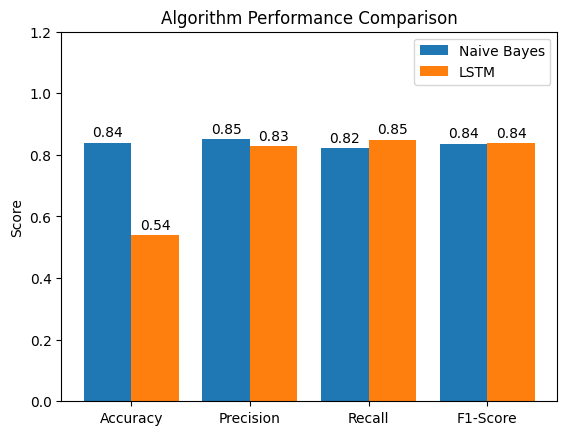

In [100]:
import matplotlib.pyplot as plt

# Create a bar chart comparing algorithm performance
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
nb_scores = [nb_accuracy, nb_precision, nb_recall, nb_f1]
lstm_scores = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]

x = range(len(metrics))

# Create bars for Naive Bayes and LSTM
nb_bars = plt.bar(x, nb_scores, width=0.4, label="Naive Bayes")
lstm_bars = plt.bar([i + 0.4 for i in x], lstm_scores, width=0.4, label="LSTM")

# Add score labels on top of each bar
for i, bar in enumerate(nb_bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

for i, bar in enumerate(lstm_bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Set the x-axis labels, title, and legend
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Algorithm Performance Comparison")
plt.legend()

# Adjust y-axis to range from 0 to 1.2
plt.ylim(0, 1.2)

plt.show()


## Conclusion
The Naive Bayes classifier excelled due to its simplicity and efficient handling of TF-IDF vectors, achieving high accuracy. In contrast, LSTM's strength lies in capturing sequential dependencies, its lower accuracy suggests potential overfitting. Naive Bayes's simpler approach proved more effective for this specific binary classification problem, likely due to the straightforward nature of sentiment analysis in movie reviews, it performed better overall here due to computational efficiency, while LSTM was defeated due to overfitting and data dependency.

# Bibliography

[1] Maas, A.L., Daly, R.E., Pham, P.T., Huang, D., Ng, A.Y. and Potts, C., 2011. Learning word vectors for sentiment analysis. In: *Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies*. Portland, Oregon, USA, June 2011. Association for Computational Linguistics, pp. 142-150. Available at: <http://www.aclweb.org/anthology/P11-1015> [Accessed 5 December 2024].


[2] Hochreiter, S. and Schmidhuber, J., 1997. Flat minima. Neural computation, 9(1), pp.1-42.


[3]Chen, S., Webb, G.I., Liu, L. and Ma, X., 2020. A novel selective naïve Bayes algorithm. Knowledge-Based Systems, 192, p.105361. Available at: https://doi.org/10.1016/j.knosys.2019.105361 [Accessed 5 December 2024].